In [1]:
from itertools import product

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import re
import spacy.lang.ro.stop_words as stop_words
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, kendalltau
import seaborn as sns

tqdm.pandas()

In [2]:
train_dataset = pd.read_csv("./datasets/train.csv")
validation_dataset = pd.read_csv("./datasets/val.csv")
test_dataset = pd.read_csv("./datasets/test.csv")

In [3]:
train_dataset

,id,text,score
0,196112,A sandwich and french bread sit on a cutting b...,-0.666667
1,514558,A baseball player is standing on the field whi...,0.000000
2,54244,A casserole served at a restaurant in a brown ...,1.333333
3,9420,OLD BLACK AND WHITE PHOTO OF AN ALL BOYS SCHOOL,1.666667
4,531512,A woman is milking a cow in the animal stable.,0.250000
...,...,...,...
7995,419064,A fire hydrant that is silver with a red top a...,1.200000
7996,344521,"A plate is filled with broccoli, apples, straw...",1.000000
7997,33652,A homemade pizza is shown with cheese and chic...,1.444444
7998,108123,The baseball player hits the ball with a stron...,-0.125000


# Score distribution

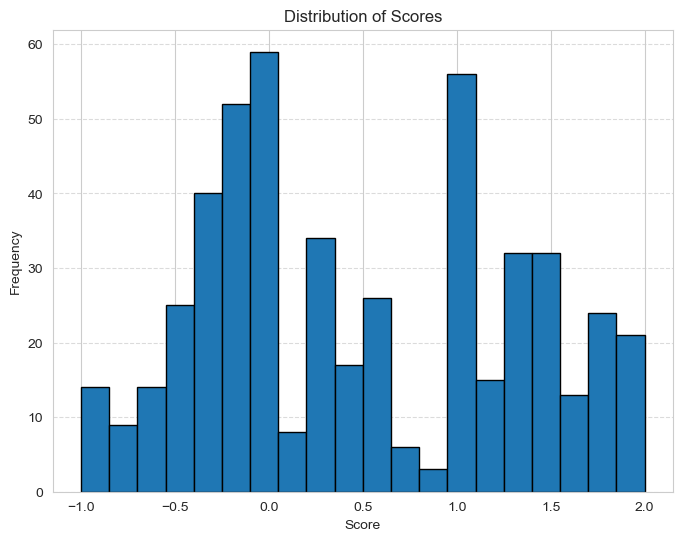

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(validation_dataset['score'], bins=20, edgecolor='black', alpha=1)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
# nlp = spacy.load("en_core_web_sm")

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")

# Convert stop words list to a set for faster lookup
sw_set = set(stop_words.STOP_WORDS)
sw_lower = set(word.lower() for word in stop_words.STOP_WORDS)

def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z@#.
    # sentence = re.sub(pattern, " ", sentence)

    # Tokenize the preprocessed sentence
    # tokenization = nlp(sentence)
    # 
    # # 4. Remove stopwords and empty tokens, and perform stemming
    # list_text_preprocessed = [
    #     token.text for token in tokenization if 
    #     not token.is_stop and 
    #     token.pos_ != "SPACE"
    # ]
    # for token in tokenization:
    #     print(
    #         f"Text: {token.text}, Lemma: {token.lemma_}, POS Tag: {token.pos_}, Dependency: {token.dep_}, "
    #         f"Stop Word?: {token.is_stop}, Entity Type: {token.ent_type_}"
    #     )
    # Join the stemmed tokens back into a sentence
    # processed_text = ' '.join(list_text_preprocessed)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii-era bomber flying out of formation'

In [6]:
train_dataset['preprocessed_text'] = train_dataset['text'].progress_apply(text_preparetion)
validation_dataset['preprocessed_text'] = validation_dataset['text'].progress_apply(text_preparetion)
test_dataset['preprocessed_text'] = test_dataset['text'].progress_apply(text_preparetion)

100%|██████████| 500/500 [00:00<?, ?it/s]


In [7]:
vectorizer = TfidfVectorizer(
    input="content",          # Process raw text (default)
    encoding="utf-8",         # Ensure correct text encoding
    decode_error="replace",   # Replace encoding errors
    strip_accents="unicode",  # Remove accents for better token consistency
    lowercase=True,           # Convert to lowercase
    analyzer="word",          # Analyze at the word level
    token_pattern=r"(?u)\b\w\w+\b",  # Use default tokenization pattern
    ngram_range=(1, 3),       # Include unigrams, bigrams, and trigrams for richer context
    max_df=0.9,               # Ignore terms that appear in more than 90% of documents (common words)
    min_df=3,                 # Include terms appearing in at least 3 documents (remove rare noise)
    max_features=1000,        # Increase feature limit for more comprehensive representation
    stop_words="english",     # Remove common English stop words
    binary=False,             # Use term frequency instead of binary counts
    dtype=np.float32,         # Use float32 for memory efficiency
    norm="l2",                # Normalize TF-IDF vectors to unit length (L2 norm)
    use_idf=True,             # Use inverse document frequency
    smooth_idf=True,          # Smooth IDF weights to avoid division by zero
    sublinear_tf=True         # Apply sublinear scaling (logarithmic) to term frequencies
)

X_train = vectorizer.fit_transform(train_dataset["text"].values)
# X = X.toarray()

X_validation = vectorizer.transform(validation_dataset["text"].values)
X_test = vectorizer.transform(test_dataset["text"].values)
# X_validation = X_validation.toarray()

y_train = train_dataset["score"].values
y_validation = validation_dataset["score"].values

In [8]:
scaler = StandardScaler(with_mean=False)

X_train = scaler.fit_transform(X_train)

X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Sentences distribution

In [9]:
pca = PCA(n_components=3)
reduced_pca = pca.fit_transform(X_train)

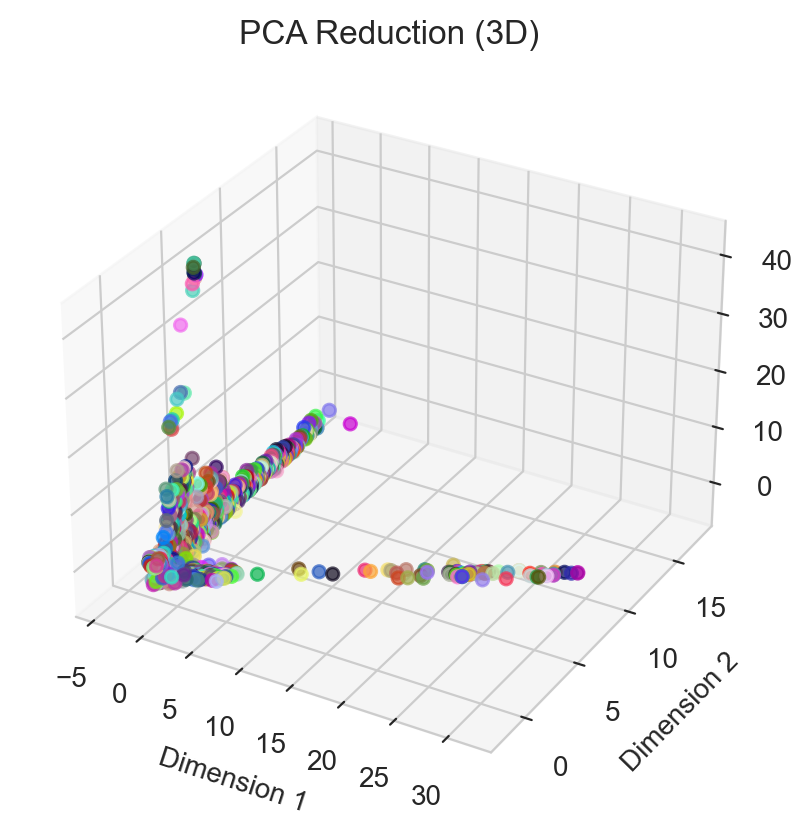

In [10]:
num_sentences = X_train.shape[0]
colors = np.random.rand(num_sentences, 3)

def plot_3d(data, title, color='blue'):
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.7, c=colors)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

# Plot PCA
plot_3d(reduced_pca, "PCA Reduction (3D)")

# SVR

In [16]:
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 1]
kernels = ['rbf']

param_combination = list(product(C_values, epsilon_values, kernels))

results = []
best_model = SVR()
best_mse = 100.0
for C, epsilon, kernel in tqdm(param_combination):
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    mae = mean_absolute_error(y_validation, y_pred)
    spearman_corr, _ = spearmanr(y_validation, y_pred)
    kendall_corr, _ = kendalltau(y_validation, y_pred)
    
    result = {
        "C": C,
        "Epsilon": epsilon,
        "MAE": float(round(mae, 2)),
        "MSE": float(round(mse, 2)),
        "Spearman Correlation": float(round(spearman_corr, 2)),
        "Kendall Correlation": float(round(kendall_corr, 2))
    }
    
    if mse < best_mse:
        best_model = model

    # print(result)
    results.append(result)

# Convert results to a dataframe
results_df = pd.DataFrame(results)
results_df

100%|██████████| 12/12 [00:38<00:00,  3.20s/it]


,C,Epsilon,MAE,MSE,Spearman Correlation,Kendall Correlation
0,0.1,0.01,0.55,0.46,0.58,0.41
1,0.1,0.10,0.55,0.46,0.58,0.41
2,0.1,1.00,0.68,0.59,0.51,0.36
3,1.0,0.01,0.53,0.45,0.58,0.41
4,1.0,0.10,0.52,0.44,0.58,0.41
5,1.0,1.00,0.65,0.56,0.45,0.31
6,10.0,0.01,0.55,0.47,0.54,0.38
7,10.0,0.10,0.54,0.47,0.54,0.38
8,10.0,1.00,0.65,0.56,0.41,0.28
9,100.0,0.01,0.55,0.49,0.53,0.37


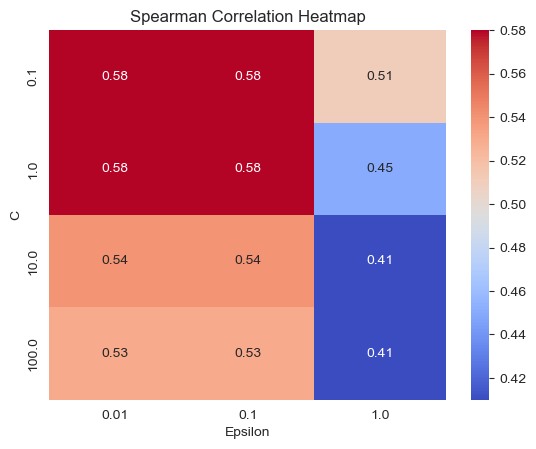

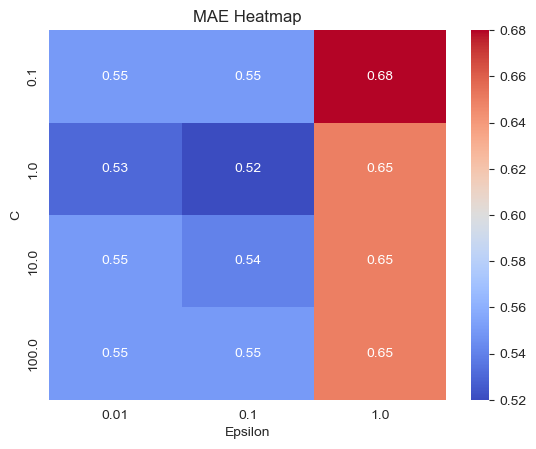

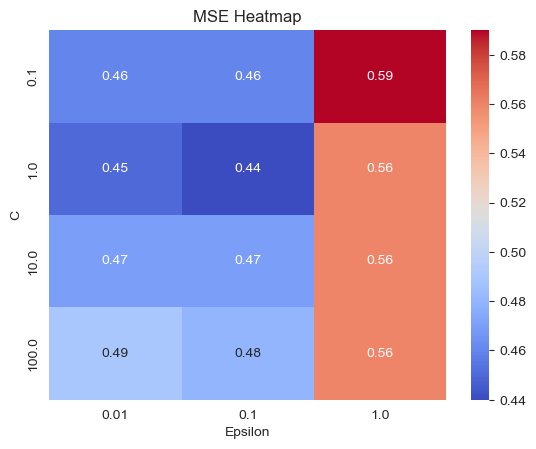

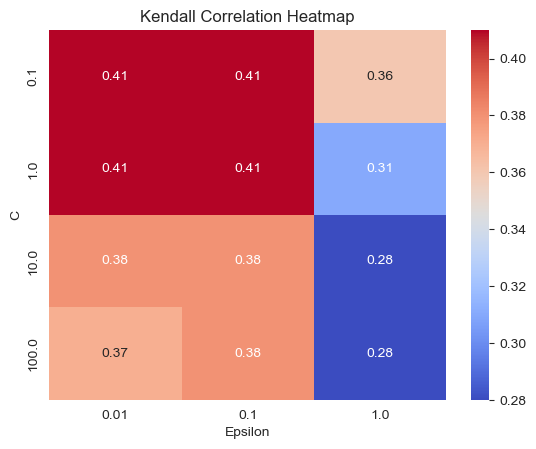

In [12]:


# Pivot table for Spearman Correlation
spearman_pivot = results_df.pivot(index="C", columns="Epsilon", values="Spearman Correlation")

# Plot heatmap for Spearman Correlation
sns.heatmap(spearman_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.show()

# Pivot table for MAE
mae_pivot = results_df.pivot(index="C", columns="Epsilon", values="MAE")

# Plot heatmap for MAE
sns.heatmap(mae_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("MAE Heatmap")
plt.show()

# Pivot table for MSE
mse_pivot = results_df.pivot(index="C", columns="Epsilon", values="MSE")

# Plot heatmap for MSE
sns.heatmap(mse_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("MSE Heatmap")
plt.show()

# Pivot table for Kendall Correlation
kendall_pivot = results_df.pivot(index="C", columns="Epsilon", values="Kendall Correlation")

# Plot heatmap for Kendall Correlation
sns.heatmap(kendall_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Kendall Correlation Heatmap")
plt.show()


# Test

In [13]:
test_dataset["score"] = best_model.predict(X_test)

In [14]:
test_dataset.drop(["text", "preprocessed_text"], axis=1, inplace=True)

In [15]:
test_dataset.to_csv("./submissions/submission.csv", index=False)